<a href="https://colab.research.google.com/github/lphohmann/DL_microbial_gene_classifier/blob/main/1D_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# to do:
- look into different ResNet architectures: wide ResNets, xresnet, resnest, ..
- bottleneck ResNet, try adding mixup callback as well
- note: if the callback is something you only want during training, you should pass it into your fit function rather than the Learner -> pass mixup into fit
- in some batches a category is not present despite weighed sampling, is that a problem?

- fix metric error: explore cause 
- fix confusion matrix to get a clear view of whats going on

# Setting everything up

In [1]:
%%capture
!pip install fastai --upgrade
#!pip install -Uqq fastbook --upgrade
#!pip install torchtext==0.8.1

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from fastai import *
from fastai.vision.all import *
from sklearn.preprocessing import OneHotEncoder

In [3]:
# mount google drive to access files and set the correct working
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/ColabNotebooks/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/DL_project
/content/drive/MyDrive/ColabNotebooks/DL_project


# Define functions required for creating the Datablock

In [4]:
# defining functions required for building the DataBlock
# one hot encoding function
def OH_enc(seq: str):
    # get the categories into array
    cats = ['K', 'D', 'N', 'E', 'R', 'A', 'T', 'L', 'I', 'Q', 'C', 'F', 'G', 'W', 'M', 'S', 'H', 'P', 'V', 'Y']
    cat_array = np.array(sorted(cats), ndmin=1) #
    # get seq into array
    trunc_seq = seq[:300] # truncate sequences longer than 300 
    seq_array = np.array(list(trunc_seq))
    #one hot encode the sequence
    onehot_encoder = OneHotEncoder(categories=[cat_array],sparse=False,handle_unknown='ignore')
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array.reshape(len(seq_array), 1))
    return np.transpose(onehot_encoded_seq)

# zero padding function
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# combine in one function
def main_item_tfms(seq): # added -> None because the tensor shape later is 1,2820 and i think it should be 20,2820
    enc_seq = OH_enc(seq)
    pad_encseq_array = pad_along_axis(enc_seq,300,1)
    return pad_encseq_array 

In [5]:
# get_x and y by specifying column in dataframe
def get_y(r): return r['Knum']
def get_x(r): 
    return main_item_tfms(r['Seq']) # apply the one hot encoding and padding function

In [6]:
# read in my data from which training and validation set will be created
trainval = pd.read_csv('trainval.csv', low_memory=False)

In [7]:
# CategoryBlock -> typetfm: categorize, batchtfm: CUDA, itemtfm: totensor
def CategoryBlock(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

In [8]:
'''
# building the datablock
dblock = DataBlock(blocks=(TransformBlock(batch_tfms=IntToFloatTensor), CategoryBlock(vocab=['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126',
       'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172',
       'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201',
       'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625',
       'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499',
       'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979',
       'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713',
       'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234',
       'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940',
       'K14941', 'K15228', 'K15229', 'K18277'])),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),
                 get_x = get_x,
                 get_y = get_y
                 )
'''

"\n# building the datablock\ndblock = DataBlock(blocks=(TransformBlock(batch_tfms=IntToFloatTensor), CategoryBlock(vocab=['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126',\n       'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172',\n       'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201',\n       'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625',\n       'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499',\n       'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979',\n       'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713',\n       'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234',\n       'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940',\n       'K14941', 'K15228', 'K15229', 'K18277'])),\n                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),\n                 get_x = get_x,\n                 get_y = get_y\n                 )\n"

In [9]:
# alt block, not specifying categories
# building the datablock
dblock = DataBlock(blocks=(TransformBlock(batch_tfms=IntToFloatTensor), CategoryBlock()),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),
                 get_x = get_x,
                 get_y = get_y
                 )

In [10]:
#dblock.summary(trainval)

# Create the dataloader

In [ ]:
# create dataloaders from datablock 
dls = dblock.dataloaders(trainval, bs=256, shuffle=True, drop_last=True) # shuffle the data to prevent overfitting due to an organized dataset and drop the last incomplete batch

In [ ]:
# visualize batch label distribution, compare with hist after balance correction
x,y = dls.one_batch()
#plt.hist(y,bins=dls.c) # if run with gpu there is a type error

In [ ]:
# access the dataset from datablock
dsets = dblock.datasets(trainval)
#dsets.train
#dsets.valid

In [ ]:
# label distribution in valid set
valid_label_count = Counter(dsets.valid.items.Knum)
#valid_label_count.most_common() # check the distribution of seqs per label

In [ ]:
# label distribution in valid set
train_label_count = Counter(dsets.train.items.Knum)
#train_label_count.most_common() # check the distribution of seqs per label

In [ ]:
# 1. calc weights for each label class
class_weights = {} # empty dict to be filled with the class weights
for label in train_label_count:
    class_weights[label] = 1/train_label_count[label] # for every category the weight is (1 / number of associated sequences)
wgts = dsets.train.items.Knum.map(class_weights).values[:len(dsets.train)] # [:len(dsets.train)] not needed
weighted_dls = dblock.dataloaders(trainval,bs=256, dl_type=WeightedDL, wgts=wgts, shuffle=True, drop_last=True) 
dls.train = weighted_dls.train # replace the train dl with a weighted dl 

# note: check in which order /type weights have to be for the weighted dataloader --> can also check later if it works by looking at batch composition

In [ ]:
# check dls attributes .c and .vocab
#dls.vocab
dls.c

In [ ]:
# check one batch to make sure the dls is constructed right (balanced)
x,y = dls.one_batch()
#y # these should be the targets 
#x # and these the encoded sequences

In [ ]:
# check the shape
x.shape #torch.Size([256, 20, 300])

In [ ]:
# check the label distribution in the batch to see if balancing was successful (note:maybe do a before and after weighing the dataloader)
#plt.hist(y,bins=dls.c)

# Functions for the Learner

In [ ]:
# the metric 
# choose one that is also fine for unbalanced datasets such as the F1score
# a majority negative class, while labels not present in the data will result in 0 components in a macro average.
F1Score = F1Score(labels=dls.vocab, average='macro') # 'macro' calculate score for each label individually, and then find their unweighted mean. penalizes poor performance on minority classes more
# alt. RocAUC?

In [ ]:
# callback to fix RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same
def cb(self): 
    new_xb = [x.type(torch.FloatTensor).cuda() for x in self.learn.xb]
    self.learn.xb = new_xb
    return self.learn.xb
t_type = Callback(before_batch=cb)

In [ ]:
# callback to save the model during training
smc = SaveModelCallback(monitor="f1_score", fname="1D_ResNet", comp=np.greater, with_opt=True) # change comp based on metric; CHANGE NAME AS WELL TO CORRECTYL SAVE MDOEL

In [ ]:
# callback to stop training when the model doesnt improve anymore
estop = EarlyStoppingCallback(monitor="f1_score", min_delta=0.001, comp=np.greater, patience=5) # change comp based on metric

# Bottleneck resnet: Book-based architecture

In [ ]:
# the stem
def _resnet_stem(*sizes): 
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2, ndim=1 if i==0 else 1) for i in range(len(sizes)-1) # ndim
    ] + [nn.MaxPool1d(kernel_size=3, stride=2, padding=1)] # 1d

m = _resnet_stem(20,32,32,64) # just add 20, to add the first layer to increate to 20 channels

In [ ]:
def _conv_block(ni,nf,stride): 
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1, ndim=1), # ndim
        ConvLayer(nf//4, nf//4, stride=stride, ndim=1), #
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero, ndim=1)) #

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None, ndim=1) # ndim
        self.pool = noop if stride==1 else nn.AvgPool1d(2, ceil_mode=True) # changed to 1d
    
    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
# putting it all together
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(20,32,32,64) # 
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion 
        blocks = [self._make_layer(*o) for o in enumerate(layers)] 
        super().__init__(*stem, *blocks,
                        nn.AdaptiveAvgPool1d(1), Flatten(), #1d
                        nn.Linear(self.block_szs[-1], n_out))

    def _make_layer(self, idx, n_layers): 
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2] 
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers) 
        ])

In [41]:
# the learner
# trying to not give a loss function to solve assertion error in confusion matrix plot
def get_learner(m):
    #return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()
    #return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), opt_func=Adam, lr=defaults.lr, cbs=[t_type,smc], metrics=[accuracy,F1Score], model_dir='models')
    return Learner(dls, m, opt_func=Adam, lr=defaults.lr, cbs=[t_type,smc], metrics=[accuracy,F1Score], model_dir='models') # trying to solve error

In [42]:
rn = ResNet(dls.c, [3,4,6,3], 4) # these group sizes make up a resnet50
learn = get_learner(rn)

In [ ]:
learn.model

# Bottleneck resnet: Training

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(minimum=0.0013182567432522773, steep=0.0030199517495930195, valley=0.00010964782268274575, slide=0.015848932787775993)

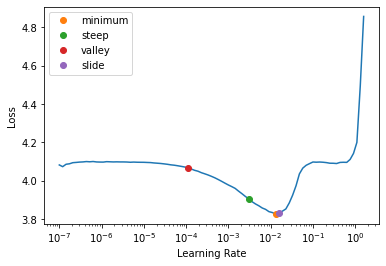

In [59]:
# choose an adequate lr
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide)) 

In [31]:
# train 
epochs=3
lr=0.00010964782268274575 # based on valley in lr_find 
learn.fit_one_cycle(epochs, lr) # appareantly some labels in y_test don't appear in y_pred and are never predicted. This messes with the weighted f-score.
# UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
# seems as they say "nor" -> check on the labels, all of them should be present in the model. maybe dls.vocab doesnt work in F1Score().

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.307068,1.933362,0.497867,0.000000,09:38
1,0.411079,1.064794,0.710649,0.000000,09:39
2,0.297633,0.931130,0.746223,0.000000,09:37


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Better model found at epoch 0 with f1_score value: 0.0.


# Bottleneck resnet: Confusion matrix and model loading

the confusion matrix always gives out errors either because of RAM overload or other things.
Next approach is to try to create a smaller dl from a sample of the validation set and then construct the matrix.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


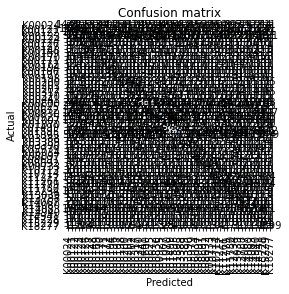

In [44]:
interp = ClassificationInterpretation.from_learner(learn) 
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # AssertionError: ==: 4975936 85792, IF I REMOVE THE LOSS FUNCTION FROM THE LEARNER IT WORKS??
# https://forums.fast.ai/t/confusion-matrix-assert-error-on-mnist/81582

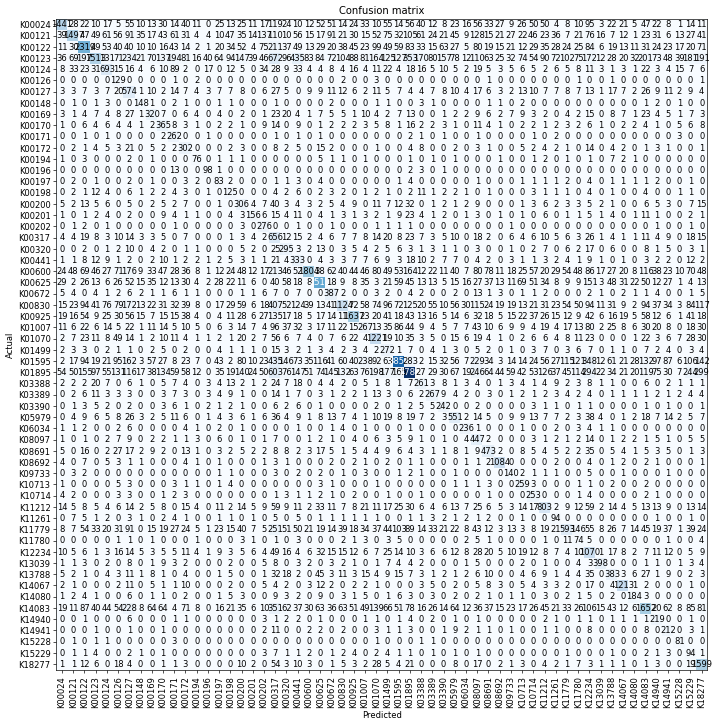

In [45]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # AssertionError: ==: 4975936 85792, IF I REMOVE THE LOSS FUNCTION FROM THE LEARNER IT WORKS??

In [40]:
# maybe without plotting
stats = interp.confusion_matrix() # assetion error again
stats

AssertionError: ignored

In [ ]:
# alt try
vpreds = learn.get_preds(1) #get preds for validation set
y_preds = list(map(int, vpreds[1])) #turn them into a list of ints
y_true = list(dls.valid_ds.items['any']) # get the validation set ground truths that are stored in a df column called any
assert len(y_true) == len(y_preds)
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
fp, fn

In [ ]:
# also gives RAM error
interp = ClassificationInterpretation.from_learner(learn) # TypeError: __init__() missing 1 required positional argument: 'losses'
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix() #AssertionError: ==: 5562084 95898

In [34]:
# monkey patch attempt to fix confusion matrix out-of-RAM error
# https://forums.fast.ai/t/unable-to-plot-confusion-matrix/68115/10
# https://forums.fast.ai/t/cannot-plot-confusion-matrix-in-colab-pro-out-of-ram-error-and-runtime-crashes/88813
@classmethod
def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx].new(shuffled=False, drop_last=False)
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None)) # set with_imputs to False

Interpretation.from_learner = from_learner
# later interp = ClassificationInterpretation.from_learner(learn) gives : TypeError: __init__() missing 1 required positional argument: 'losses'

In [53]:
# alternative monkey patch attempt: doesnt work, i think because the @classmethod decorator is the lost during patching
@patch
def from_learner(x: Interpretation,**kwargs):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx].new(shuffled=False, drop_last=False)
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None)) # set with_imputs to False

# Bottleneck resnet: Loading the model for inference

In [43]:
# load the model (is it possible to continue training?)
learn = learn.load('1D_ResNet') 
# model summary print out
# do lr_find again before continuing training?

In [ ]:
# load the model not for training but for making predictions (inference)
learn_inf = load_learner(path/'modelname.pkl')

In [ ]:
# make prediction
learn_inf.predict('images/grizzly.jpg') # image as example
'''returned three things: the predicted category in the same format you originally provided 
(in this case, that’s a string), the index of the predicted category, and the probabilities of each category
The last two are based on the order of categories in the vocab of the DataLoaders '''
# check vocab
learn_inf.dls.vocab

# Defining the architecture for a 1D CNN (not ResNet)

In [76]:
# ConvLayer creates a sequence of convolutional (ni to nf), ReLU (if use_activ) and norm_type layers
def block(ni, nf): return ConvLayer(ni, nf, stride=2, ndim=1, ks=5)

In [77]:
def get_model():
    return nn.Sequential(
        block(20, 32), #how to handle this
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool1d(1),
        Flatten(),
        nn.Linear(256, 58)) 

In [79]:
# metric
#precision = Precision(average='weighted') 
# Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
# create learn object

#learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy) # switched metric from accuracy to precision for assessing dataset balance

In [80]:
#learn.model

Sequential(
  (0): ConvLayer(
    (0): Conv1d(20, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): AdaptiveAvgPool1d(output_size=1)
  (5): Flatten(full=False)
  (6): Linear(in_features=256, out_features=58, bias=True)
)

In [78]:
# try with cnn learner instead
#learn = cnn_learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), pretrained = False, metrics = accuracy)

TypeError: ignored

In [ ]:
#learn.summary()

In [ ]:
#learn.lr_find() # choose an adequate lr

In [ ]:
#from fastai.callbacks import SaveModelCallback

In [ ]:
# fit and train 
epochs=1
lr=0.1
learn = learn.fit_one_cycle(epochs, lr) #callbacks=[SaveModelCallback(learn, every='epoch',  monitor='accuracy', name='saved_1D_net')]) # make training more stable with fit_one_cycle

epoch,train_loss,valid_loss,accuracy,time
0,0.078036,0.079609,0.979353,12:01


In [ ]:
#len(dls.train_ds)
#type(learn) # it looks like after .fit the resulting learn object is of type None for some reason. 
# i think i have to pass a parameter when creating the learner so that some stats are saved to later build the confusion matrix
#learn.dls
learn.model

Sequential(
  (0): ConvLayer(
    (0): Conv1d(20, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): AdaptiveAvgPool1d(output_size=1)
  (5): Flatten(full=False)
  (6): Linear(in_features=256, out_features=58, bias=True)
)

In [ ]:
# confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=100)


In [ ]:
# save the architecture and the parameters
learn.export()

In [ ]:
# check that the file exists
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
# load the model not for training but for making predictions (inference)
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# make prediction
learn_inf.predict('images/grizzly.jpg') # image as example
'''returned three things: the predicted category in the same format you originally provided 
(in this case, that’s a string), the index of the predicted category, and the probabilities of each category
The last two are based on the order of categories in the vocab of the DataLoaders '''
# check vocab
learn_inf.dls.vocab
